# Capstone Project_Plant Pathology

## DenseNet Model

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Data preprocessing
from sklearn.model_selection import train_test_split # ML preprocessing

# Validation
from sklearn.metrics import roc_auc_score

In [3]:
import keras

Using TensorFlow backend.
C:\Users\aafat\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aafat\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aafat\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aafat\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [4]:
from keras.layers import Input

from keras import layers, models

from keras.optimizers import Adam, SGD

from keras.callbacks import CSVLogger, LearningRateScheduler

from keras.applications import DenseNet121 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation ,Flatten

from keras.layers import GlobalAveragePooling2D
from keras.models import Model # Define model

from keras.callbacks import ReduceLROnPlateau

In [5]:
#from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img ,save_img

### Load Dataset

In [6]:
test_data = pd.read_csv("../Data/test.csv")
train_data = pd.read_csv('../Data/balance_train.csv')

In [7]:
%%time
images = []
for i in train_data['image_id']:
    img_path ='..\images\\' + i + '.jpg' # locate the path of image
    image = img_to_array(load_img(img_path, target_size=(215, 215,3))) / 255 # this is a PIL image
    images.append(image) # add image to the list
    
test_images = []
for i in test_data['image_id']:
    img_path ='..\images\\' + i + '.jpg'
    image = img_to_array(load_img(img_path, target_size=(215, 215,3))) / 255 # this is a PIL image
    test_images.append(image)

Wall time: 2min 4s


In [8]:
X = np.array(images) # save images as array
X_test = np.array(test_images) # save images as array

In [9]:
y = train_data.iloc[:,1:5] # selecting classes as a target

In [20]:
y_train = np.array(y.values, dtype='float32')

In [28]:
X.shape , X_test.shape , y.shape , y_train.shape

((2489, 215, 215, 3), (1821, 215, 215, 3), (2489, 4), (2489, 4))

In [27]:
len(y)

2489

In [29]:
# split train data to subset data ( train and validation)
x_train, x_val, y_train, y_val = train_test_split(X, y , test_size=.30, random_state=42)

In [30]:
x_val.shape , x_train.shape

((747, 215, 215, 3), (1742, 215, 215, 3))

In [31]:
densenet = DenseNet121()

In [32]:
# Define model architecture

sd=[]

epochs = 10
learning_rate = 0.001
decay_rate = 5e-6
momentum = 0.9

input_shape = X[0].shape

model=Sequential()

x_in = layers.Input(shape=input_shape)

x = layers.Conv2D(3, (3, 3), padding='same')(x_in)
x = densenet(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1742, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(747, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

output = Dense(4, activation="sigmoid", name="root")(x)

model = Model(inputs=x_in, outputs=output)

sgd = SGD(lr=learning_rate ,momentum=momentum, decay=decay_rate, nesterov=False)

# Compile model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

model.summary() # print model layers

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 215, 215, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 215, 215, 3)       84        
_________________________________________________________________
densenet121 (Model)          (None, 1000)              8062504   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_1 (Dense)              (None, 1742)              1743742   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1742)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 747)               1302

In [33]:
# Fitting the model
den_hist = model.fit(x_train,y_train,epochs=30,verbose=1,validation_data=(x_val,y_val))

Train on 1742 samples, validate on 747 samples
Epoch 1/30
1742/1742 [==============================] - 882s 506ms/step - loss: 1.3791 - accuracy: 0.4024 - val_loss: 1.3849 - val_accuracy: 0.2784
Epoch 2/30
1742/1742 [==============================] - 831s 477ms/step - loss: 0.9247 - accuracy: 0.6906 - val_loss: 1.3731 - val_accuracy: 0.2825
Epoch 3/30
1742/1742 [==============================] - 836s 480ms/step - loss: 0.6927 - accuracy: 0.8088 - val_loss: 1.3397 - val_accuracy: 0.3414
Epoch 4/30
1742/1742 [==============================] - 816s 469ms/step - loss: 0.5427 - accuracy: 0.8467 - val_loss: 1.2377 - val_accuracy: 0.4833
Epoch 5/30
1742/1742 [==============================] - 796s 457ms/step - loss: 0.4433 - accuracy: 0.8731 - val_loss: 1.0839 - val_accuracy: 0.5850
Epoch 6/30
1742/1742 [==============================] - 805s 462ms/step - loss: 0.3410 - accuracy: 0.8995 - val_loss: 0.8658 - val_accuracy: 0.7216
Epoch 7/30
1742/1742 [==============================] - 856s 491m

In [35]:
den_hist.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

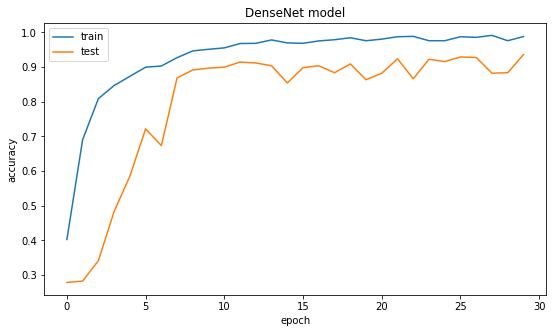

In [48]:
# summarize history for accuracy
fig = plt.figure(figsize=(9,5))
plt.plot(den_hist.history['accuracy'])
plt.plot(den_hist.history['val_accuracy'])
plt.title('DenseNet model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('DenseNet model accuracy', bbox_inches='tight', transparent=False, dpi='figure', quality=95)

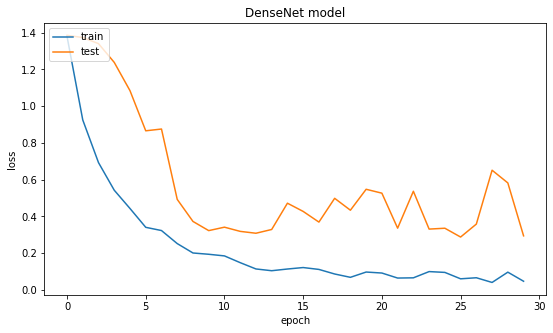

In [38]:
# summarize history for loss
fig = plt.figure(figsize=(9,5))
plt.plot(den_hist.history['loss'])
plt.plot(den_hist.history['val_loss'])
plt.title('DenseNet model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('DenseNet model accuracy', bbox_inches='tight', transparent=False, dpi='figure', quality=95)

In [39]:
# Make prediction

predict = model.predict(X_test)

In [40]:
prediction = np.ndarray(shape = (test_data.shape[0],4), dtype = np.float32)
for row in range(test_data.shape[0]):
    for col in range(4):
        if predict[row][col] == max(predict[row]):
            prediction[row][col] = 1
        else:
            prediction[row][col] = 0
            
prediction = pd.DataFrame(prediction)
prediction.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
df2 = pd.concat([test_data.image_id, prediction], axis = 1)

## Save model

In [43]:
import pickle
# save the model to disk
filename = 'Plant_2489_DenseNet121_ep30_lr0_001_v3.sav'
pickle.dump(model, open(filename, 'wb'))
filename2 = 'Plant_2489_DenseNet121_ep30_lr0_001_v3.pkl'
pickle.dump(model, open(filename2, 'wb'))

## Prediction

In [44]:
# prediction
y_pred = model.predict(x_val)

# print roc74_auc score
print("roc_auc score : {}".format(roc_auc_score(y_true= y_val, y_score=y_pred, average="weighted").round(3)))

roc_auc score : 0.984


In [45]:
df2

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.0,0.0,1.0,0.0
1,Test_1,0.0,0.0,1.0,0.0
2,Test_2,0.0,0.0,0.0,1.0
3,Test_3,1.0,0.0,0.0,0.0
4,Test_4,0.0,0.0,1.0,0.0
...,...,...,...,...,...
1816,Test_1816,0.0,0.0,1.0,0.0
1817,Test_1817,0.0,1.0,0.0,0.0
1818,Test_1818,0.0,0.0,1.0,0.0
1819,Test_1819,1.0,0.0,0.0,0.0


In [46]:
df2.to_csv('Plant_DenseNet121_ep30_lr0_001_v3_test_imgs.csv', index = False)

In [47]:
#Check score on testing data
loss_test, acc_test = model.evaluate(x_val, y_val)

print(f'Test accuracy: {acc_test:.3f}')
print(f'Test loss: {loss_test:.3f}')

747/747 [==============================] - 102s 137ms/step
Test accuracy: 0.936
Test loss: 0.295
